In [1]:
# Basic Libraries
import sys
import time
import gc
import random
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# PyTorch Libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import gc 

# Data Handling and Image Processing
from torchvision import datasets, transforms

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from skimage.metrics import structural_similarity as ssim

# Style for Matplotlib
import scienceplots
plt.style.use('science')
plt.style.use(['no-latex'])

# Scientific Computing and Machine Learning
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.linalg import subspace_angles
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr

# Custom Modules and Extensions
sys.path.append("../netrep/")
sys.path.append("../svcca/")
import cca_core
from netrep.metrics import LinearMetric
import networks as nets  # Contains RNNs
import net_helpers
import mpn_tasks
import helper
import mpn

import scienceplots
plt.style.use('science')
plt.style.use(['no-latex'])

# Memory Optimization
gc.collect()
torch.cuda.empty_cache()

In [2]:
# 0 Red, 1 blue, 2 green, 3 purple, 4 orange, 5 teal, 6 gray, 7 pink, 8 yellow
c_vals = ['#e53e3e', '#3182ce', '#38a169', '#805ad5','#dd6b20', '#319795', '#718096', '#d53f8c', '#d69e2e',]
c_vals_l = ['#feb2b2', '#90cdf4', '#9ae6b4', '#d6bcfa', '#fbd38d', '#81e6d9', '#e2e8f0', '#fbb6ce', '#faf089',]
c_vals_d = ['#9b2c2c', '#2c5282', '#276749', '#553c9a', '#9c4221', '#285e61', '#2d3748', '#97266d', '#975a16',]
l_vals = ['solid', 'dashed', 'dotted', 'dashdot', '-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 10))]
markers_vals = ['o', 'v', '^', '<', '>', '1', '2', '3', '4', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']
hyp_dict = {}

Set seed 284
Fixation_off: True; Task_info: True
Rules: ['delaydm1']
  Input size 7, Output size 3
Using CUDA...
Align ['delaydm1'] With Same Time
delaydm1
[7, 50, 50, 3]
MultiPlastic Net:
  output neurons: 3
  Act: tanh

=== Layer Specific Setup ===
  MP Layer1 parameters:
    n_neurons - input: 50, output: 50
    M matrix parameters:    update bounds - Max mult: 1.0, Min mult: -1.0
      type: mult // Update - type: hebb_assoc // Act fn: linear
      Eta: scalar (fixed) // Lambda: scalar (fixed) // Lambda_max: 0.90 (tau: 4.0e+02)
How about Test Data at dataset 0
Train parameters:
  Loss: MSE // LR: 1.00e-03 // Optim: adam
  Grad type: backprop // Gradient clip: 1.0e+01
Weight reg: None
Activity reg: None
Iter: 0, LR: 1.000e-03 - train_loss:3.517e-01, rounded train_acc:0.090, valid_loss:3.722e-01, rounded valid_acc:0.090
Iter: 100, LR: 1.000e-03 - train_loss:1.323e-01, rounded train_acc:0.340, valid_loss:1.401e-01, rounded valid_acc:0.324
Iter: 200, LR: 1.000e-03 - train_loss:1.090e-0

/tmp/ipykernel_25059/3264826506.py:266: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,1,figsize=(3,3))


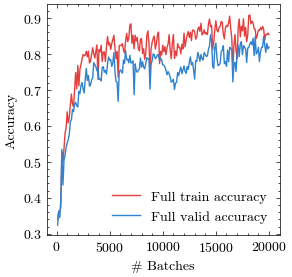

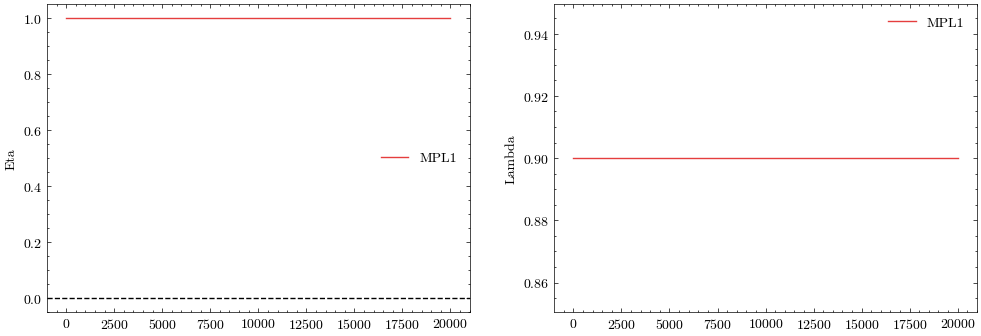

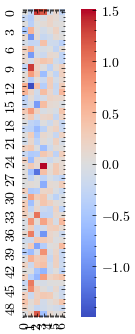

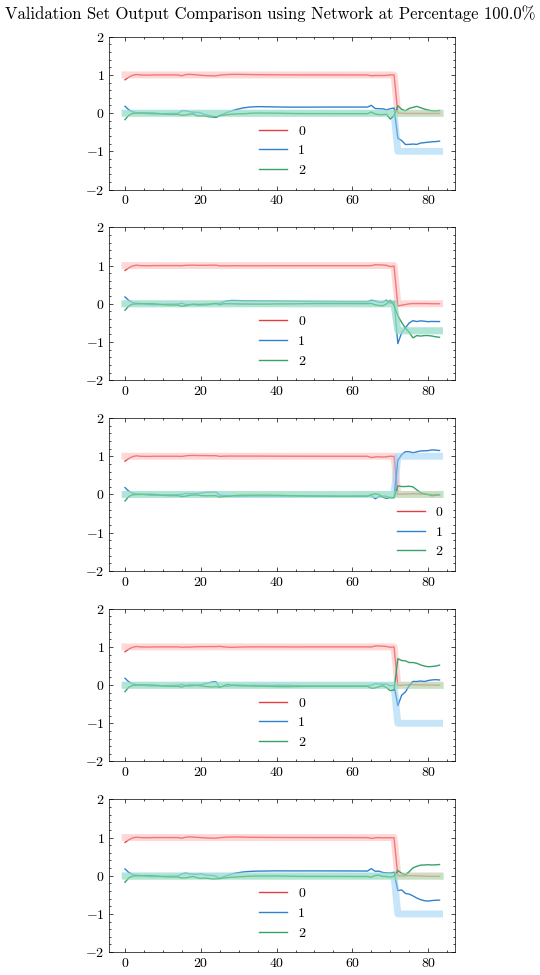

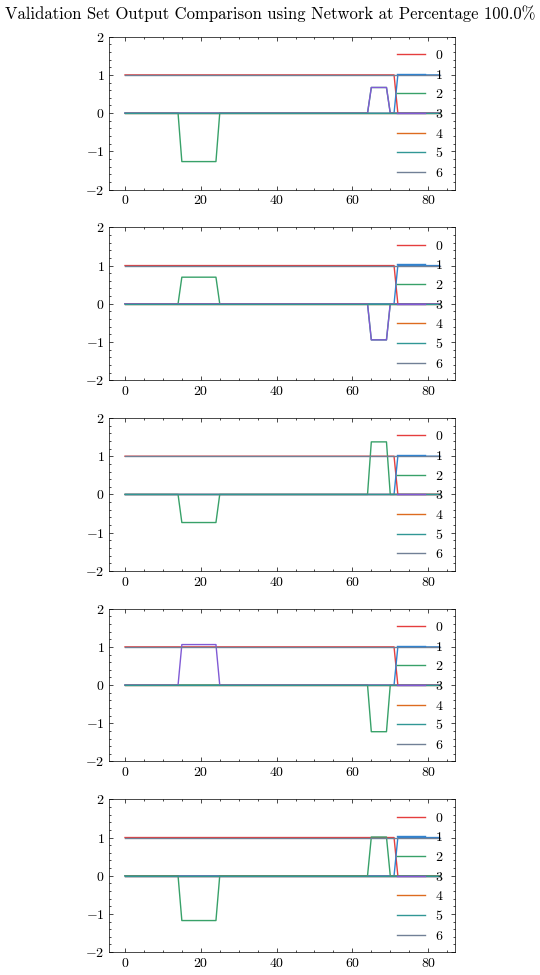

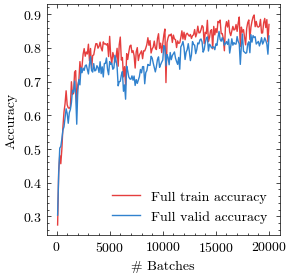

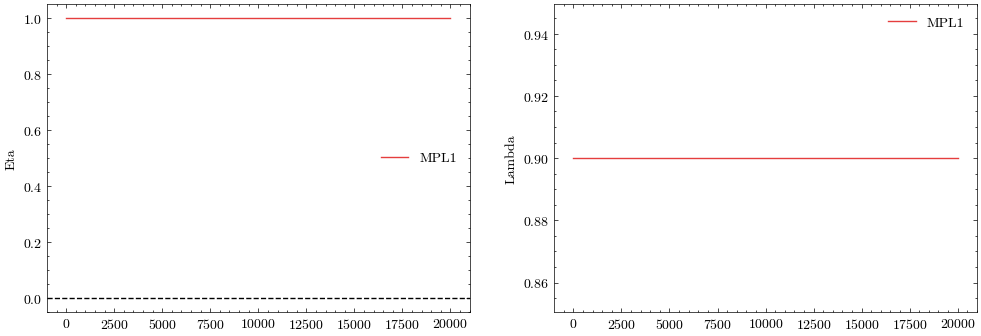

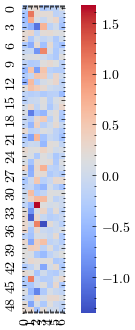

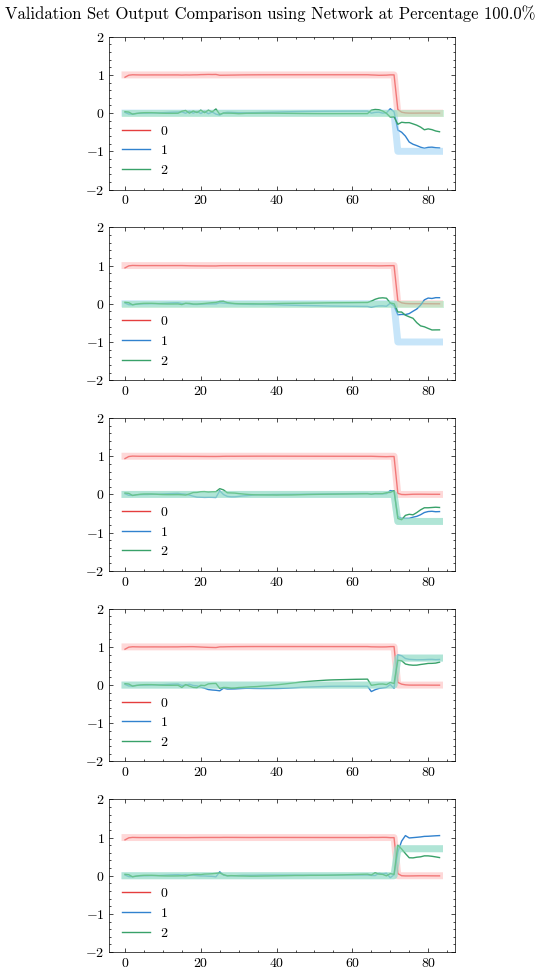

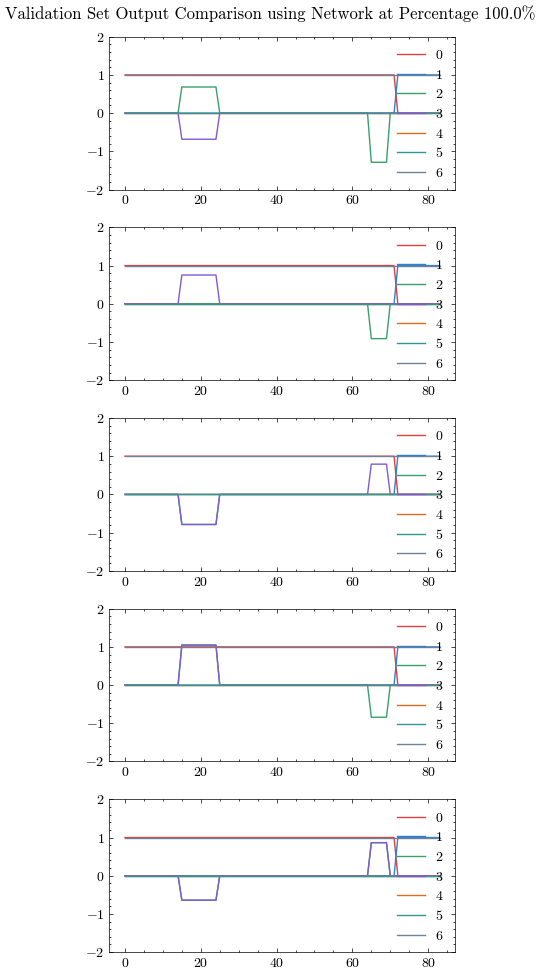

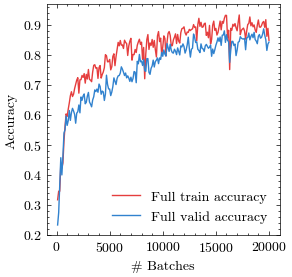

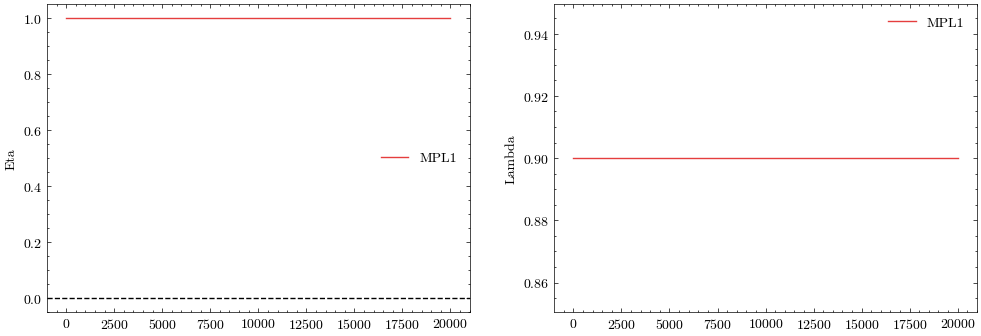

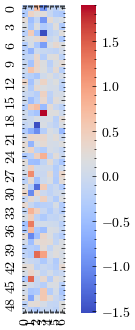

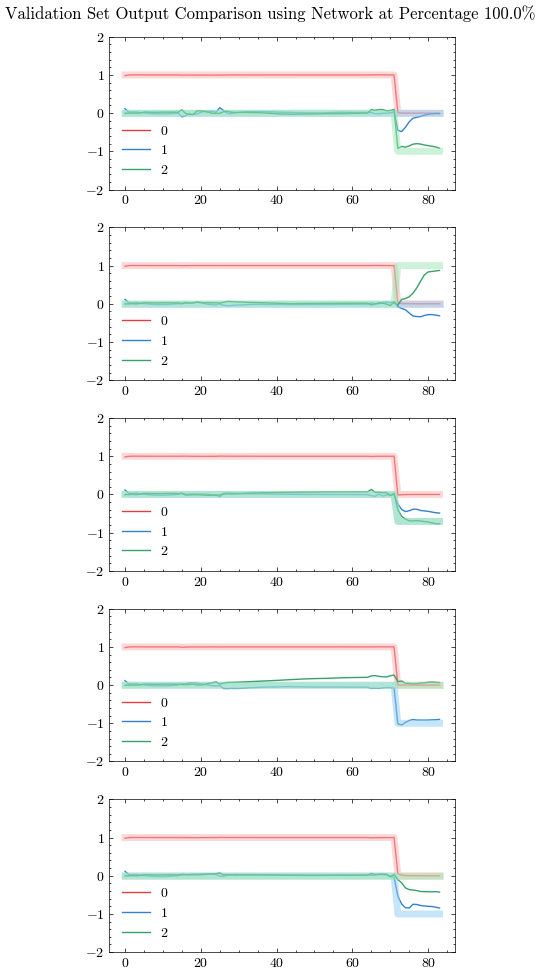

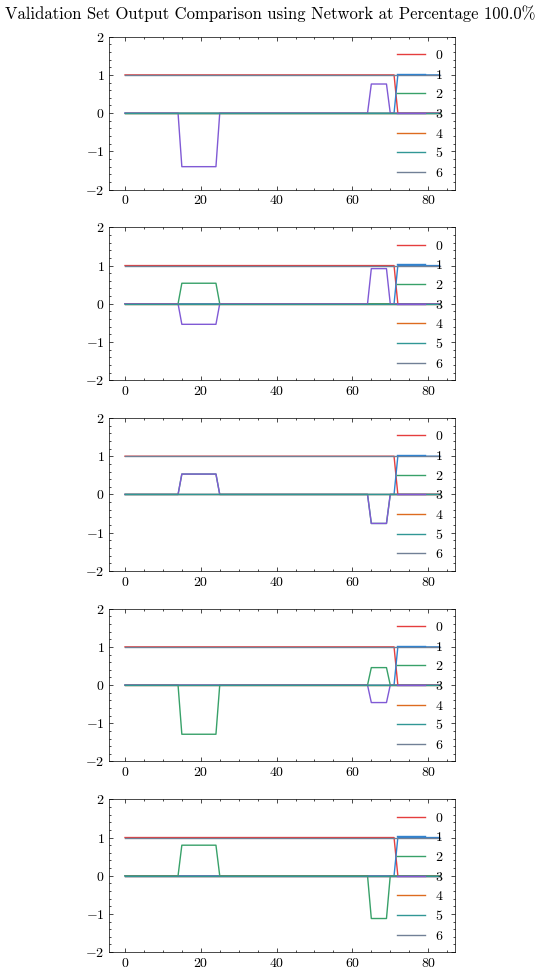

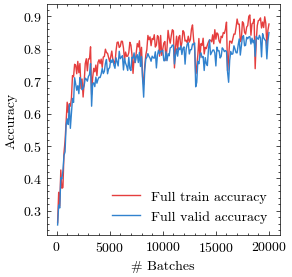

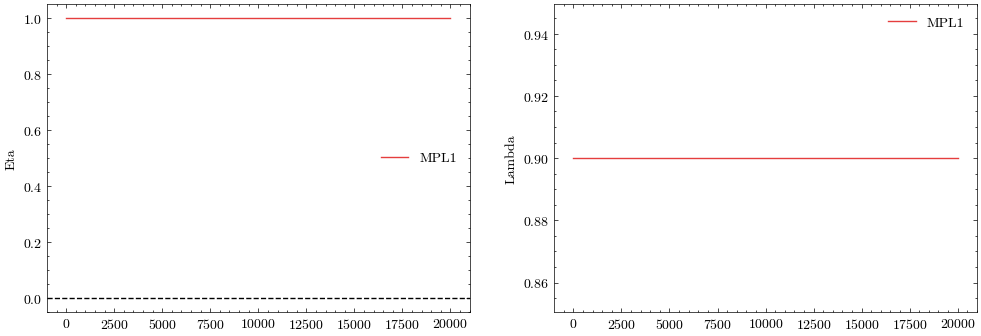

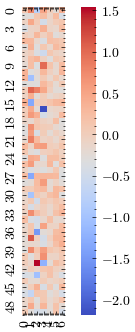

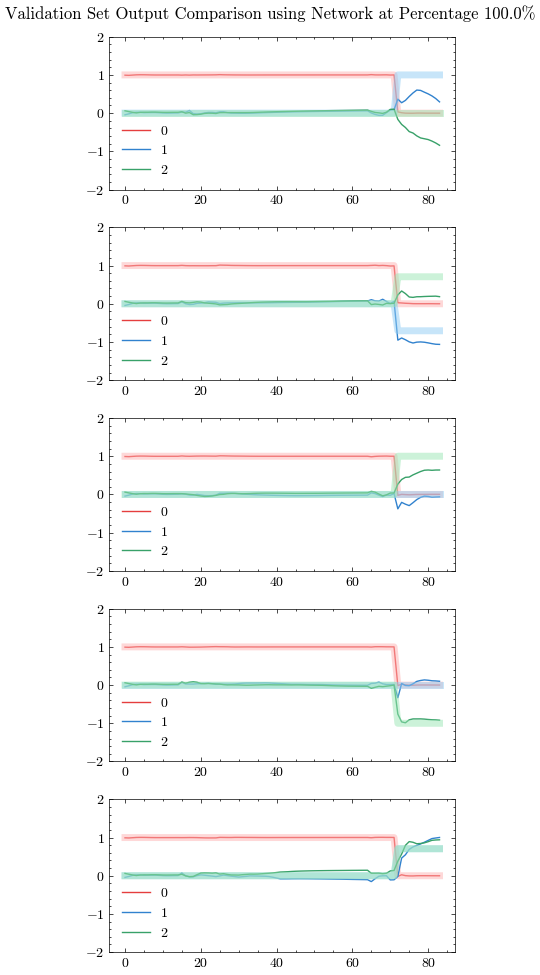

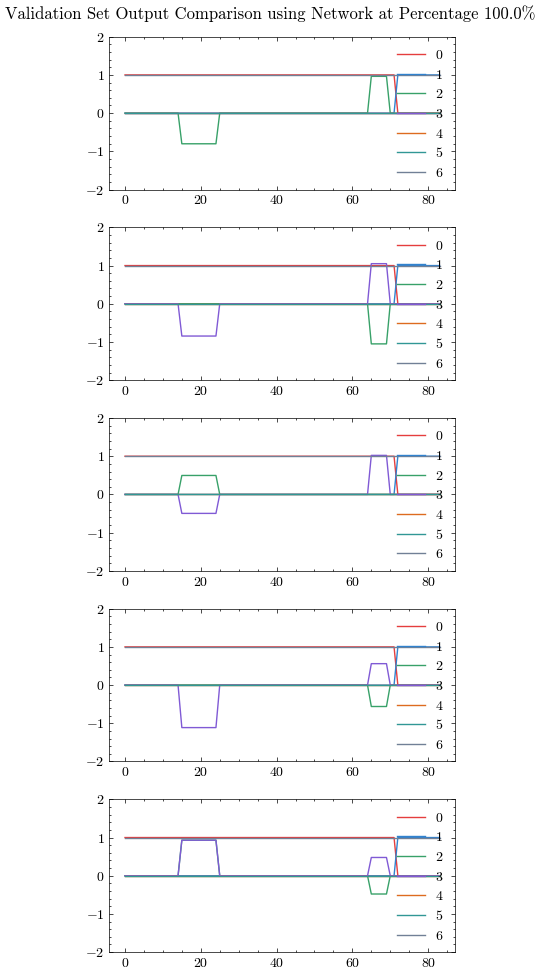

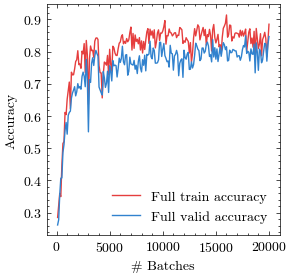

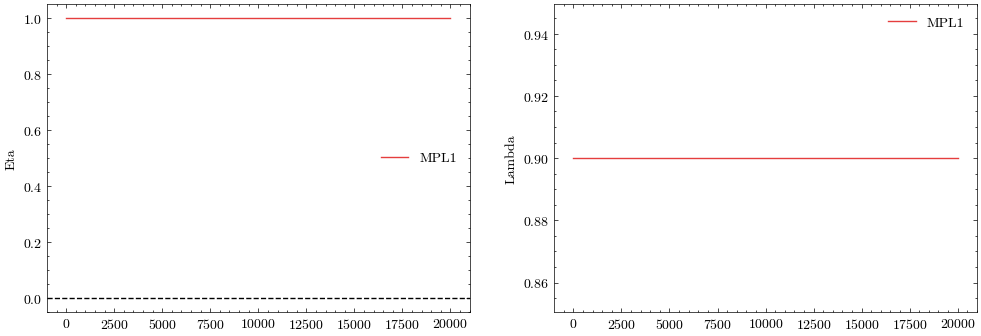

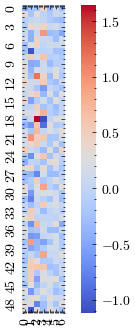

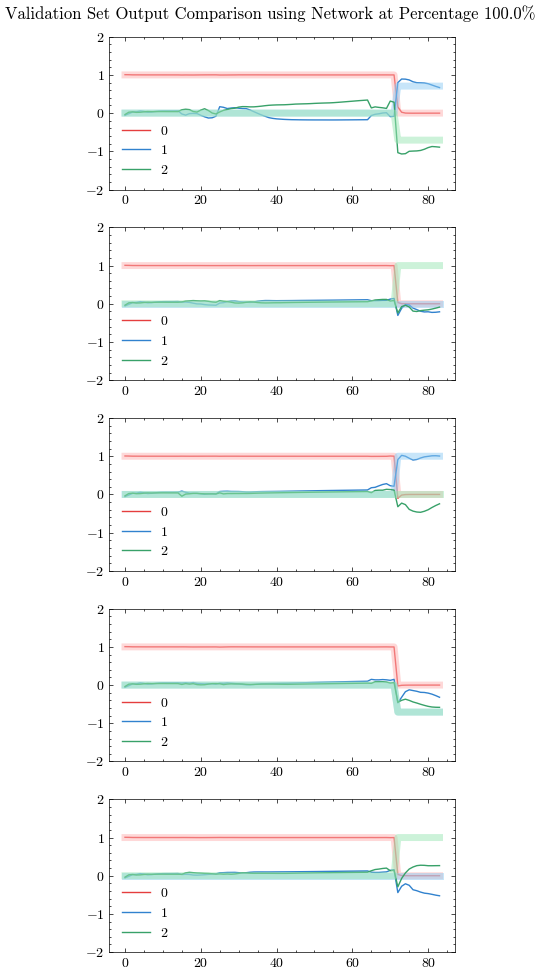

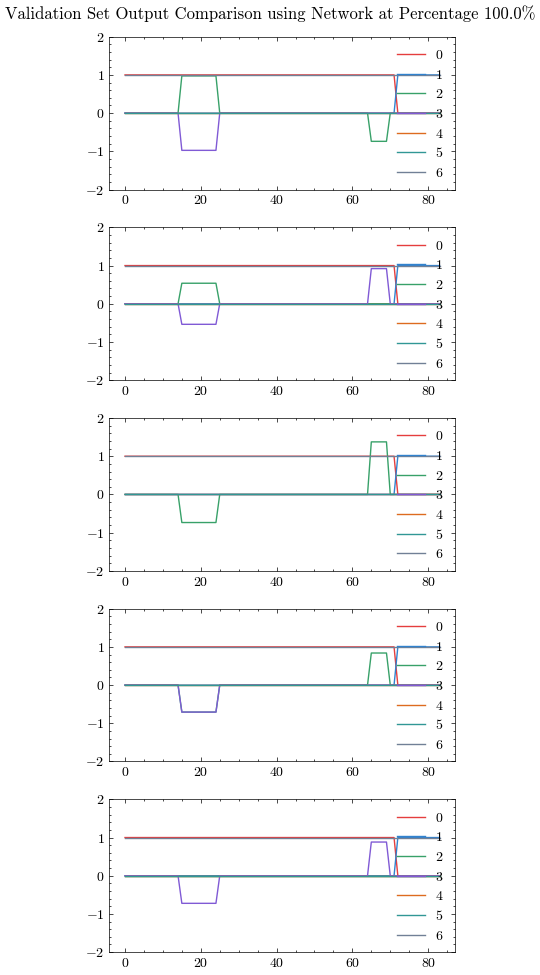

In [3]:
# Reload modules if changes have been made to them
from importlib import reload

reload(nets)
reload(net_helpers)

for _ in range(5):
    fixseed = False # randomize setting the seed may lead to not perfectly solved results
    seed = random.randint(1,1000) if not fixseed else 8 # random set the seed to test robustness by default
    print(f"Set seed {seed}")
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    hyp_dict['task_type'] = 'multitask' # int, NeuroGym, multitask
    hyp_dict['mode_for_all'] = "random_batch"
    hyp_dict['ruleset'] = 'delaydm1' # low_dim, all, test
    
    accept_rules = ('fdgo', 'fdanti', 'delaygo', 'delayanti', 'reactgo', 'reactanti', 
                    'delaydm1', 'delaydm2', 'dmsgo', 'dmcgo', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm', 'dm1')
    
    rules_dict = \
        {'all' : ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
                  'dm1', 'dm2', 'contextdm1', 'contextdm2', 'multidm',
                  'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
                  'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo'],
         'low_dim' : ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
                     'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
                     'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo'],
    
         'gofamily': ['fdgo', 'fdanti', 'reactgo', 'reactanti', 'delaygo', 'delayanti'],
    
         'delaygo': ['delaygo'],
         'delaygofamily': ['delaygo', 'delayanti'],
         'fdgo': ['fdgo'],
         'fdfamily': ['fdgo', 'fdanti'],
         'reactgo': ['reactgo'],
         'reactfamily': ['reactgo', 'reactanti'],
         
         'delaydm1': ['delaydm1'],
         'delaydmfamily': ['delaydm1', 'delaydm2'],
         
         'dmsgofamily': ['dmsgo', 'dmsnogo'],
         'dmsgo': ['dmsgo'],
         'dmcgo': ['dmcgo'],
         'contextdelaydm1': ['contextdelaydm1'], 
         'contextdelayfamily': ['contextdelaydm1', 'contextdelaydm2'],
         'dm1': ['dm1']
        }
        
    
    # This can either be used to set parameters OR set parameters and train
    train = True # whether or not to train the network
    verbose = True
    hyp_dict['run_mode'] = 'minimal' # minimal, debug
    hyp_dict['chosen_network'] = "dmpn"
    
    # suffix for saving images
    hyp_dict['addon_name'] = "eta_scalar_lambda_scalar_notlearn_samemodality_nostrength"
    
    mpn_depth = 1
    
    # for coding 
    if hyp_dict['chosen_network'] in ("gru", "vanilla"):
        mpn_depth = 1
    
    def current_basic_params():
        task_params = {
            'task_type': hyp_dict['task_type'],
            'rules': rules_dict[hyp_dict['ruleset']],
            'dt': 40, # ms, directly influence sequence lengths,
            'ruleset': hyp_dict['ruleset'],
            'n_eachring': 8, # Number of distinct possible inputs on each ring
            'in_out_mode': 'low_dim',  # high_dim or low_dim or low_dim_pos (Robert vs. Laura's hardtask, resp)
            'sigma_x': 0.00, # Laura raised to 0.1 to prevent overfitting (Robert uses 0.01)
            'mask_type': 'cost', # 'cost', None
            'fixate_off': True, # Second fixation signal goes on when first is off
            'task_info': True, 
            'randomize_inputs': False,
            'n_input': 20, # Only used if inputs are randomized,
            'modality_diff': False,  # if two stimulus are included in the task, put them into different modality,
            'label_strength': False,
            'long_delay': 'normal' 
        }
    
        print(f"Fixation_off: {task_params['fixate_off']}; Task_info: {task_params['task_info']}")
    
        train_params = {
            'lr': 1e-3,
            'n_batches': 640,
            'batch_size': 640,
            'gradient_clip': 10,
            'valid_n_batch': 200,
            'n_datasets': 100, # Number of distinct batches
            'n_epochs_per_set': 200, # longer/shorter training
            # 'task_mask': None, # None, task
            # 'weight_reg': 'L2',
            # 'reg_lambda': 1e-4,
        }
    
        if not train: # some 
            assert train_params['n_epochs_per_set'] == 0
    
        n_hidden = 50
    
        net_params = {
            'net_type': hyp_dict['chosen_network'], # mpn1, dmpn, vanilla
            'n_neurons': [1] + [n_hidden] * mpn_depth + [1],
            'output_bias': False, # Turn off biases for easier interpretation
            'loss_type': 'MSE', # XE, MSE
            'activation': 'tanh', # linear, ReLU, sigmoid, tanh, tanh_re, tukey, heaviside
            'cuda': True,
            'monitor_freq': 100,
            'monitor_valid_out': True, # Whether or not to save validation output throughout training
            'output_matrix': '',# "" (default); "untrained", or "orthogonal"
            'input_layer_add': True, 
            'input_layer_add_trainable': True,
            'input_layer_bias': True,
            
            # for one-layer MPN, GRU or Vanilla
            'ml_params1': {
                'bias': True, # Bias of layer
                'mp_type': 'mult',
                'm_update_type': 'hebb_assoc', # hebb_assoc, hebb_pre
                'eta_type': 'scalar', # scalar, pre_vector, post_vector, matrix
                'eta_train': False,
                # 'eta_init': 'gaussian', 
                'lam_type': 'scalar', # scalar, pre_vector, post_vector, matrix
                'm_time_scale': 400, # ms, sets lambda
                'lam_train': False,
                'W_freeze': False  
            },

    
            # Vanilla RNN params
            'leaky': True,
            'alpha': 0.2,
        }
    
        # actually I don't think it is needed
        # putting here to warn the parameter checking every time 
        # when switching network
        if hyp_dict['chosen_network'] in ("gru", "vanilla"):
            assert f'ml_params' in net_params.keys()
    
        return task_params, train_params, net_params
    
    task_params, train_params, net_params = current_basic_params()
    
    shift_index = 1 if not task_params['fixate_off'] else 0
    
    if hyp_dict['task_type'] in ('multitask',):
        task_params, train_params, net_params = mpn_tasks.convert_and_init_multitask_params(
            (task_params, train_params, net_params)
        )
    
        net_params['prefs'] = mpn_tasks.get_prefs(task_params['hp'])
    
        print('Rules: {}'.format(task_params['rules']))
        print('  Input size {}, Output size {}'.format(
            task_params['n_input'], task_params['n_output'],
        ))
    else:
        raise NotImplementedError()
    
    if net_params['cuda']:
        print('Using CUDA...')
        device = torch.device('cuda')
    else:
        print('Using CPU...')
        device = torch.device('cpu')
    
    ##############
    ##############
    hyp_dict["mess_with_training"] = False
    
    if hyp_dict['mess_with_training']:
        hyp_dict['addon_name'] += "messwithtraining"
    
    params = task_params, train_params, net_params
    
    # random matrix
    random_matrix = None
    if task_params["randomize_inputs"]:
        random_matrix = task_params["randomize_matrix"]
    
    if net_params['net_type'] == 'mpn1':
        netFunction = mpn.MultiPlasticNet
    elif net_params['net_type'] == 'dmpn':
        netFunction = mpn.DeepMultiPlasticNet
    elif net_params['net_type'] == 'vanilla':
        netFunction = nets.VanillaRNN
    elif net_params['net_type'] == 'gru':
        netFunction = nets.GRU
    
    ##############
    ##############
    test_n_batch = train_params["valid_n_batch"]
    color_by = "stim"
    
    task_random_fix = True
    if task_random_fix:
        print(f"Align {task_params['rules']} With Same Time")
    
    if task_params['task_type'] in ('multitask',): # Test batch consists of all the rules
        task_params['hp']['batch_size_train'] = test_n_batch
        # using homogeneous cutting off
        test_mode_for_all = "random"
        # ZIHAN
        # generate test data using "random"
        # also aligned strength setting as in the training data
        test_data, test_trials_extra = mpn_tasks.generate_trials_wrap(task_params, test_n_batch, \
                rules=task_params['rules'], mode_input=test_mode_for_all, fix=task_random_fix
        )
        _, test_trials, test_rule_idxs = test_trials_extra
    
        task_params['dataset_name'] = 'multitask'
    
        if task_params['in_out_mode'] in ('low_dim_pos',):
            output_dim_labels = ('Fixate', 'Cos', '-Cos', 'Sin', '-Sin')
        elif task_params['in_out_mode'] in ('low_dim',):
            output_dim_labels = ('Fixate', 'Cos', 'Sin')
        else:
            raise NotImplementedError()
    
        labels = []
        for rule_idx, rule in enumerate(task_params['rules']):
            print(rule)
            if rule in accept_rules:
                if hyp_dict['ruleset'] in ('dmsgo', 'dmcgo'):
                    labels.append(test_trials[rule_idx].meta['matches'])
                else:
                    labels.append(test_trials[rule_idx].meta['resp1' if color_by == "resp" else 'stim1'])
    
            else:
                raise NotImplementedError()
        labels = np.concatenate(labels, axis=0).reshape(-1,1)
    
    test_input, test_output, test_mask = test_data
    
    permutation = np.random.permutation(test_input.shape[0])
    test_input = test_input[permutation]
    test_output = test_output[permutation]
    test_mask = test_mask[permutation]
    labels = labels[permutation]
    
    test_input_np = test_input.detach().cpu().numpy()
    test_output_np = test_output.detach().cpu().numpy()
    
    n_batch_all = test_input_np.shape[0] # Total number of batches, might be different than test_n_batch
    max_seq_len = test_input_np.shape[1]
    
    if task_params["randomize_inputs"]: 
        rmat = task_params["randomize_matrix"]
        test_input_np = np.matmul(test_input_np, np.linalg.pinv(rmat))
    
    ##############
    ##############
    # we use net at different training stage on the same test_input
    net, _, (counter_lst, netout_lst, db_lst, Winput_lst, Winputbias_lst, \
             Woutput_lst, Wall_lst, marker_lst, loss_lst, acc_lst) = net_helpers.train_network(params, device=device, verbose=verbose, train=train, hyp_dict=hyp_dict, netFunction=netFunction, test_input=test_input)
    
    
    ##############
    ##############
    if train:
        fig, ax = plt.subplots(1,1,figsize=(3,3))
        ax.plot(net.hist['iters_monitor'][1:], net.hist['train_acc'][1:], color=c_vals[0], label='Full train accuracy')
        ax.plot(net.hist['iters_monitor'][1:], net.hist['valid_acc'][1:], color=c_vals[1], label='Full valid accuracy')
        if net.weight_reg is not None:
            ax.plot(net.hist['iters_monitor'], net.hist['train_loss_output_label'], color=c_vals_l[0], zorder=-1, label='Output label')
            ax.plot(net.hist['iters_monitor'], net.hist['train_loss_reg_term'], color=c_vals_l[0], zorder=-1, label='Reg term', linestyle='dashed')
            ax.plot(net.hist['iters_monitor'], net.hist['valid_loss_output_label'], color=c_vals_l[1], zorder=-1, label='Output valid label')
            ax.plot(net.hist['iters_monitor'], net.hist['valid_loss_reg_term'], color=c_vals_l[1], zorder=-1, label='Reg valid term', linestyle='dashed')
        
        # ax.set_yscale('log')
        ax.legend()
        # ax.set_ylabel('Loss ({})'.format(net.loss_type))
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('# Batches')
        fig.savefig(f"./hardtask/loss_{hyp_dict['ruleset']}_mpndepth_{mpn_depth}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)
        
    print('Done!')
    
    ##############
    ##############
    if train:
        net_helpers.net_eta_lambda_analysis(net, net_params, hyp_dict)
    
    ##############
    ##############
    if hyp_dict['chosen_network'] == "dmpn":
        if net_params["input_layer_add"]:
            input_matrix = net.W_initial_linear.weight.data.detach().cpu().numpy()
            figinp, axsinp = plt.subplots(1,1,figsize=(4,4))
            sns.heatmap(input_matrix, ax=axsinp, square=True, cmap='coolwarm')
    
    ##############
    ##############
    use_finalstage = False
    if use_finalstage:
        # plotting output in the validation set
        net_out, db = net.iterate_sequence_batch(test_input, run_mode='track_states')
        W_output = net.W_output.detach().cpu().numpy()
    
        W_all_ = []
        for i in range(len(net.mp_layers)):
            W_all_.append(net.mp_layers[i].W.detach().cpu().numpy())
        W_ = W_all_[0]
        
    else:
        ind = len(marker_lst)-1
        # ind = 0
        network_at_percent = (marker_lst[ind]+1)/train_params['n_datasets']*100
        print(f"Using network at {network_at_percent}%")
        net_out = netout_lst[ind]
        db = db_lst[ind]
        W_output = Woutput_lst[ind]
        if net_params["net_type"] == "dmpn":
            W_ = Wall_lst[ind][0]
    
    if net_params['loss_type'] in ('MSE',):
        fig, axs = plt.subplots(5, 1, figsize=(4, 5*2))
        figin, axsin = plt.subplots(5, 1, figsize=(4, 5*2))
    
        if test_output_np.shape[-1] == 1:
            for batch_idx, ax in enumerate(axs):
                ax.plot(net_out[batch_idx, :, 0], color=c_vals[batch_idx])
                ax.plot(test_output_np[batch_idx, :, 0], color=c_vals_l[batch_idx])
    
        else:
            for batch_idx, ax in enumerate(axs):
                task_label = test_input_np[batch_idx, 0, 6-shift_index:]
                # task_label_index = np.where(task_label == 1)[0][0] 
                task_label_index = np.where(np.isclose(task_label, 1, atol=0.1))[0][0]
                for out_idx in range(test_output_np.shape[-1]):
                    axs[batch_idx].plot(net_out[batch_idx, :, out_idx], color=c_vals[out_idx], label=out_idx)
                    axs[batch_idx].plot(test_output_np[batch_idx, :, out_idx], color=c_vals_l[out_idx], linewidth=5, alpha=0.5)
                axs[batch_idx].legend()
                axs[batch_idx].set_ylim([-2, 2])
    
                input_batch = test_input[batch_idx,:,:].cpu().numpy()
                for inp_idx in range(input_batch.shape[-1]):
                    axsin[batch_idx].plot(input_batch[:,inp_idx], color=c_vals[inp_idx], label=inp_idx)
                axsin[batch_idx].legend()
                axsin[batch_idx].set_ylim([-2, 2])
    
        fig.suptitle(f"Validation Set Output Comparison using Network at Percentage {network_at_percent}%")
        fig.tight_layout()
        fig.savefig(f"./hardtask/lowD_{hyp_dict['ruleset']}_mpndepth_{mpn_depth}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)
    
        figin.suptitle(f"Validation Set Output Comparison using Network at Percentage {network_at_percent}%")
        figin.tight_layout()
        figin.savefig(f"./hardtask/lowD_{hyp_dict['ruleset']}_input_mpndepth_{mpn_depth}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

In [4]:
print(db.keys())

dict_keys(['hidden_pre1', 'hidden1', 'M1', 'b1'])
